In [1]:
import torch
from torch import nn

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class Model_V1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(Model_V1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units*2*128*128, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [4]:
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = Path("data")
image_path = Path(data_path / "Indian Food")

if image_path.exists():
  print(f"{image_path} already exists....Skipping creation")
else:
  print(f"Creating {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

  print(f"Creating train and test directories")
  train_path = Path(image_path / "train")
  test_path = Path(image_path / "test")
  train_path.mkdir(parents=True, exist_ok=True)
  test_path.mkdir(parents=True, exist_ok=True)

folder_path = Path(image_path / "train" / "Train Food Classification")
if not folder_path.exists():
  !unzip /content/drive/MyDrive/PyTorch/"Train Food Classification.zip" -d /content/data/"Indian Food"/train

folder_path = Path(image_path / "test" / "Test Food Classification")
if not folder_path.exists():
  !unzip /content/drive/MyDrive/PyTorch/"Test Food Classification.zip" -d /content/data/"Indian Food"/test

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/179.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/180.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/181.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/182.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/183.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/184.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/185.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/186.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/188.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/190.jpg  
  inflating: /content/data/Indian Food/train/Train Food Classification/dosa/191.jpg  
  i

In [6]:
image_path = Path("data/Indian Food")
train_dir = Path(image_path / "train" / "Train Food Classification")
test_dir = Path(image_path / "test" / "Test Food Classification")

In [7]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")

Random image path: data/Indian Food/train/Train Food Classification/pakode/248.jpg


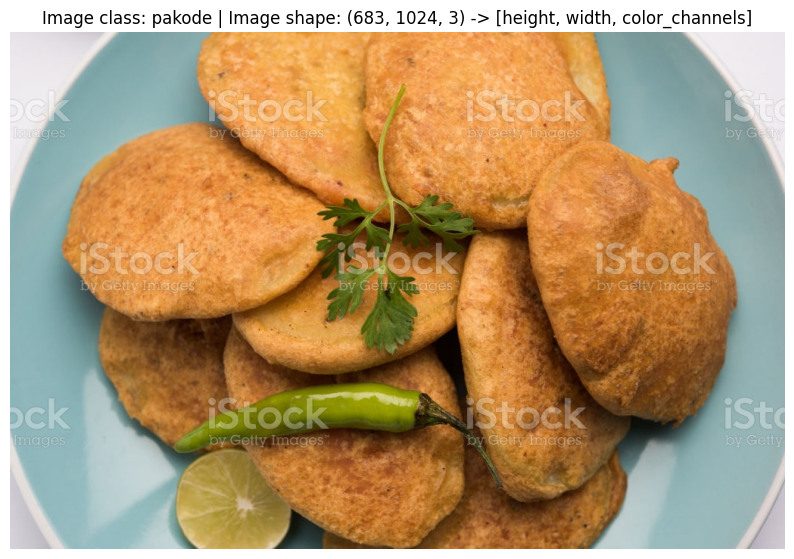

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Data Transformation

In [9]:
data_transform = transforms.Compose([transforms.Resize(size=(512,512)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.RandomHorizontalFlip(p=0.2),
                                     transforms.ToTensor()
                                     ])

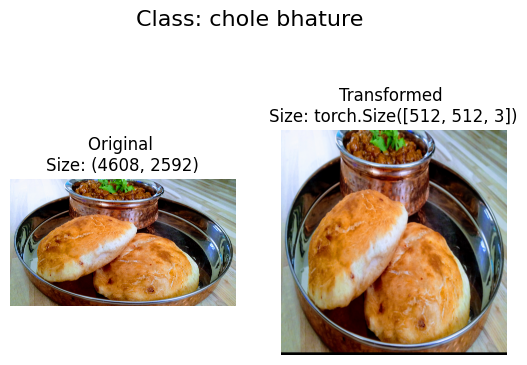

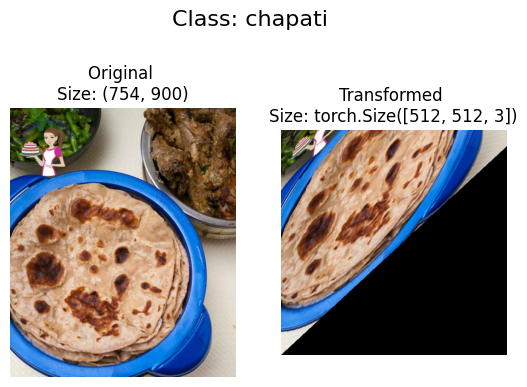

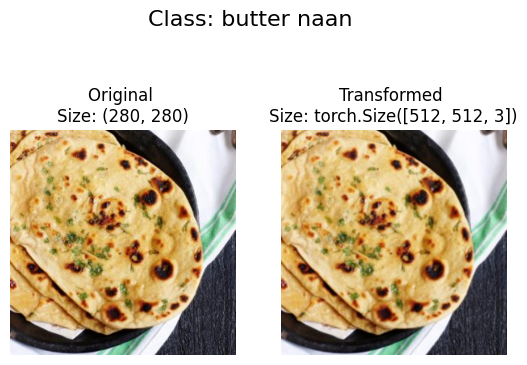

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [11]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 6492
    Root location: data/Indian Food/train/Train Food Classification
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               RandomHorizontalFlip(p=0.2)
               ToTensor()
           )

In [12]:
class_names = train_data.classes
class_names

['biryani',
 'burger',
 'butter naan',
 'chai',
 'chapati',
 'chole bhature',
 'dal makhani',
 'dosa',
 'fried rice',
 'idli',
 'jalebi',
 'kaathi rolls',
 'kulfi',
 'momos',
 'paani puri',
 'pakode',
 'paneer',
 'pav bhaji',
 'pizza',
 'samosa']

In [13]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
model = Model_V1(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001, momentum = 0.9)

In [16]:
model.load_state_dict(torch.load('/content/drive/My Drive/PyTorch/model0.pth'))

from tqdm.auto import tqdm

model.train()
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Epoch {epoch + 1}/{epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")

    if (epoch + 1) % 10 == 0:
        print(f"[Log] Epoch {epoch + 1} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")

torch.save(model.state_dict(), '/content/drive/My Drive/PyTorch/model0.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.8544 | Accuracy: 0.7646
Epoch 2/10 | Loss: 0.8519 | Accuracy: 0.7700
Epoch 3/10 | Loss: 0.8405 | Accuracy: 0.7690
Epoch 4/10 | Loss: 0.8890 | Accuracy: 0.7574
Epoch 5/10 | Loss: 0.8546 | Accuracy: 0.7565
Epoch 6/10 | Loss: 0.8338 | Accuracy: 0.7703
Epoch 7/10 | Loss: 0.8613 | Accuracy: 0.7653
Epoch 8/10 | Loss: 0.8394 | Accuracy: 0.7676
Epoch 9/10 | Loss: 0.8391 | Accuracy: 0.7730
Epoch 10/10 | Loss: 0.8106 | Accuracy: 0.7732
[Log] Epoch 10 | Loss: 0.8106 | Accuracy: 0.7732


In [17]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()
    test_loss, test_acc = 0, 0
    actual_class_names = []
    predicted_class_names = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            actual_class_names.extend([class_names[label] for label in y])
            predicted_class_names.extend([class_names[label] for label in test_pred_labels])
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    for actual, predicted in zip(actual_class_names, predicted_class_names):
        print(f"Actual: {actual}, Predicted: {predicted}")

    print(f"test_loss : {test_loss} | test_acc : {test_acc}")


In [18]:
# test_step(model=model,
#           dataloader=test_dataloader,
#           loss_fn=loss_fn)

In [19]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [20]:
summary(model=model)

Layer (type:depth-idx)                   Param #
Model_V1                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       560
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       3,620
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       7,240
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       14,440
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      13,107,220
Total params: 13,133,080
Trainable params: 13,133,080
Non-trainable params: 0

In [21]:
len(class_names)

20

In [22]:
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[-4.2209e-02,  2.6416e-02,  1.1268e-01],
                        [-6.4337e-02, -1.1573e-01,  1.6585e-01],
                        [ 1.4331e-01,  2.2555e-01,  2.0310e-01]],
              
                       [[-1.6766e-01,  6.1424e-02,  2.5082e-03],
                        [ 1.7979e-01,  1.8259e-01, -4.7564e-02],
                        [-1.7682e-01, -4.3108e-04, -1.6113e-01]],
              
                       [[-2.7604e-02, -1.4102e-01, -1.6881e-01],
                        [-1.4407e-01,  4.0429e-02,  1.3168e-01],
                        [ 2.0824e-01, -1.5285e-01,  1.1056e-01]]],
              
              
                      [[[-1.5157e-01,  1.0017e-01, -1.0589e-01],
                        [-7.5245e-02,  1.6714e-02, -1.1351e-01],
                        [ 1.3656e-02, -9.7604e-03, -2.1792e-01]],
              
                       [[ 2.4787e-01,  2.4629e-01,  1.1807e-01],
                        [ 1.8112e-01,  3.1